In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import fsolve
from scipy.optimize import minimize_scalar

In [2]:
def generate_data(n_dims, n_atoms, n_old, n_new, sparse_level, noise):
    
    # Create and normalize true dictionary true_dict
    true_dict = np.random.randn(n_dims, n_atoms)
    true_dict /= np.linalg.norm(true_dict, axis=0, keepdims=True)

    def create_coefficient_matrix(n_samples, atom_range):
        filter_mat = np.zeros((n_atoms, n_samples))
        for i in range(n_samples):
            selected_indices = np.random.choice(atom_range, sparse_level, replace=False)
            filter_mat[selected_indices, i] = (0.8 * np.random.rand(sparse_level) + 0.2) * (2 * np.random.randint(0, 2, sparse_level) - 1)
        return filter_mat

    # Create true coefficient matrix for the old dataset
    X_old = create_coefficient_matrix(n_old, round(4 * n_atoms / 5))
    old_data = true_dict @ X_old + noise * np.random.randn(n_dims, n_old)

    # Create true coefficient matrix for the new dataset
    X_new = create_coefficient_matrix(n_new, range(round(3 * n_atoms / 5), n_atoms))
    new_data = true_dict @ X_new + noise * np.random.randn(n_dims, n_new)

    return true_dict, X_old, old_data, X_new, new_data

In [3]:
# Generating Data
np.random.seed(123)

n_atoms = 50;    #number of atoms
n_dims = 25;     # number of dimensions
n_old = 250;     # number of lower-level samples
n_new = 200;     # number of upper-level samples
sparse_level = 5 # number of non_zero elements in each column of coefficient matrix
threshold = 0.9  # threshold for similarity measure
noise = 0.01     # Gaussian noise


true_dict, X_old, old_data, X_new, new_data = generate_data(n_dims, n_atoms, n_old, n_new, sparse_level, noise)
print("Shape of old_data:", old_data.shape)
print("Shape of true dictionary:", true_dict.shape)
print("Shape of new_data:", new_data.shape)

Shape of old_data: (25, 250)
Shape of true dictionary: (25, 50)
Shape of new_data: (25, 200)


In [4]:
def loss_func(Dict, coefficient_mat, data):
    return np.linalg.norm(data - Dict @ coefficient_mat)**2 / (2)

def exact_line_search(Dict, direction, coefficient_mat, data):
    """
    Perform exact line search to find the optimal step size.
    """
    def objective(step_size):
        D_temp = (1 - step_size) * Dict + step_size * direction
        return loss_func(D_temp, coefficient_mat, data)
    
    result = minimize_scalar(objective, bounds=(0, 1), method='bounded')
    return result.x

def similarity_measure(Dict, true_dict, threshold):
    """
    Calculate similarity between true dictionary and reconstructed dictionary.
    """
    
    # Normalize columns of dictionary
    Dict /= (np.linalg.norm(Dict, axis=0, keepdims=True) + np.finfo(float).eps)
    true_dict /= (np.linalg.norm(true_dict, axis=0, keepdims=True) + np.finfo(float).eps)
    num_atoms = true_dict.shape[1]
    correlation = np.dot(Dict.T, true_dict)
    n_similar = np.sum(np.max(np.abs(correlation), axis=0) > threshold)
    similarity = n_similar / num_atoms
    return similarity


def frank_wolfe_lower(data, max_iteration):
    """
    Frank-Wolfe algorithm for sparse coding with a sparsity constraint.
    """
    np.random.seed(123)
    m, n = data.shape
    delta = 3
    
    # Initialization of dictionary D and sparse matrix x
    D_init = np.random.randn(m, num_atoms)   
    D_init /= (np.linalg.norm(D_init, axis=0, keepdims=True) + np.finfo(float).eps)
    x_init = np.zeros((num_atoms, n))
    
    D = D_init.copy()
    x = x_init.copy()
    
    # Loss vectors
    loss_phase_1 = []
    loss_phase_2 = []
    gap_phase_1 = []
    gap_phase_2 = []
    similarity_phase_1  = []
    similarity_phase_2  = []
    
    
    
    """    FIRST PHASE: computing x and D    """
        
    for iter1 in range(max_iteration):
        
        # Compute the gradients with respect to x and D
        grad_x = D.T @ (D @ x - data)
        grad_D = (D @ x - data) @ x.T

        D_direction = -grad_D / (np.linalg.norm(grad_D, axis=0, keepdims=True) + np.finfo(float).eps)

        # Find the best atoms by indices of the largest absolute gradient values
        index = np.argmax(np.abs(grad_x), axis=0)
        x_direction = np.zeros_like(x)
        for j in range(n):
            x_direction[index[j], j] = -delta * np.sign(grad_x[index[j], j])

        # Compute the Frank-Wolfe gap
        gap_phase_1_val = np.trace(-grad_x.T @ (x_direction - x)) + np.trace(-grad_D.T @ (D_direction - D))
        gap_phase_1.append(gap_phase_1_val)

        # Update x and D
        step_size = 1 / np.sqrt(iter1 + 1)

        x = (1 - step_size) * x + step_size * x_direction
        D = (1 - step_size) * D + step_size * D_direction
        
        
        loss_phase_1.append(loss_func(D, x, data))
        similarity_phase_1.append(similarity_measure(D, true_dict,threshold))
        
        # Check the Frank-Wolfe gap for convergence criterion
        if gap_phase_1_val < 1e-6:
            break
            
    loss_phase_1 = loss_phase_1[:iter1]
    gap_phase_1 = gap_phase_1[:iter1]
    similarity_phase_1  = similarity_phase_1[:iter1]
    
    
    """    SECOND PHASE: fixing x and computing D    """
        
    for iter2 in range(max_iteration):

        # Compute the gradient
        grad_D = (D @ x - data) @ x.T
        D_direction = -grad_D / (np.linalg.norm(grad_D, axis=0, keepdims=True) + np.finfo(float).eps)

        # Compute the Frank-Wolfe gap
        gap_phase_2_val = np.trace(-grad_D.T @ (D_direction - D))
        gap_phase_2.append(gap_phase_2_val)
         
        # Update D
        step_size = exact_line_search(D, D_direction, x, data)
        step_size = min(step_size, 1)
    
        D = (1 - step_size) * D + step_size * D_direction

        
        loss_phase_2.append(loss_func(D, x, data))
        similarity_phase_2.append(similarity_measure(D, true_dict,threshold))

        # Check the Frank-Wolfe gap for convergence criterion
        if gap_phase_2_val < 1e-10:
            break
    
    loss_phase_2 = loss_phase_2[:iter2]
    gap_phase_2 = gap_phase_2[:iter2]
    similarity_phase_2  = similarity_phase_2[:iter2]
    
    loss_lower_level = np.concatenate([loss_phase_1,loss_phase_2],axis=0)
    gap_lower_level = np.concatenate([gap_phase_1,gap_phase_2],axis=0)
    similarity_lower_level  = np.concatenate([similarity_phase_1,similarity_phase_2],axis=0)
    
    
    # Plotting
    plt.figure(figsize=(9, 3))
    plt.style.use("bmh")

    # Plot loss_lower_level
    plt.subplot(1, 3, 1)
    plt.plot(loss_lower_level, color='green')
    plt.title('Loss Lower Level')
    plt.xlabel('Iteration')
    plt.ylabel('Loss')
    
    # Plot gap_lower_level
    plt.subplot(1, 3, 2)
    plt.plot(gap_phase_1, color='red')
    plt.title('Gap Lower Level')
    plt.xlabel('Iteration')
    plt.ylabel('Gap')
 
    # Plot similarity_lower_level
    plt.subplot(1, 3, 3)
    plt.plot(similarity_lower_level)
    plt.title('Similarity Lower Level')
    plt.xlabel('Iteration')
    plt.ylabel('Similarity')

    
    plt.tight_layout()
    plt.show()


    return x, D

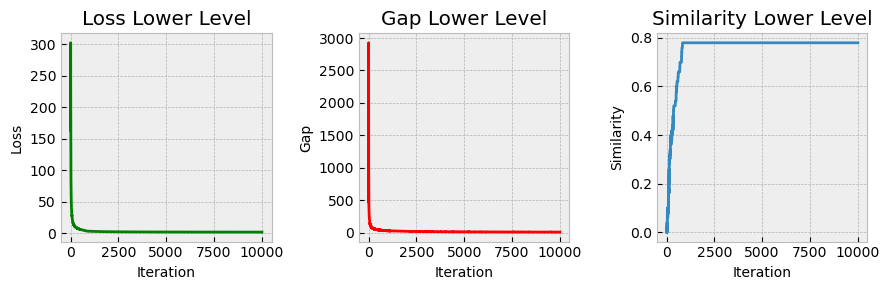

In [5]:
"Running Frank Wolfe on Lower Level"

max_iteration = 10000
num_atoms = 40

x_final_lower, D_final_lower = frank_wolfe_lower(old_data, max_iteration)

In [6]:
"Extra adjustments for the upper level problem (expanding dictionary by 10 atoms)"

D_final_lower = np.hstack([D_final_lower, np.zeros((old_data.shape[0], 10))])
x_final_lower = np.vstack([x_final_lower, np.zeros((10, old_data.shape[1]))])


D_final_lower.shape, x_final_lower.shape


((25, 50), (50, 250))

In [7]:
def find_opt_direction(grad_upper, grad_lower, Beta):

    def D_temp(grad_upper, grad_lower, param_lambda):
        """Calculate D for a given param_lambda."""
        return -(grad_upper + param_lambda * grad_lower) / (np.linalg.norm(grad_upper + param_lambda * grad_lower, axis=0) + np.finfo(float).eps)

    def lambda_formula(param_lambda):
        """Solve for param_lambda."""
        return np.trace(grad_lower.T @ D_temp(grad_upper, grad_lower, param_lambda)) - Beta

    # Compute D
    D_sub = -grad_upper / (np.linalg.norm(grad_upper, axis=0) + np.finfo(float).eps)

    # Check the constraint
    if np.trace(grad_lower.T @ D_sub) <= Beta:
        D_direction = D_sub
        return D_direction

    optimal_lambda, = fsolve(lambda_formula, 0)

    # Calculate D_direction using the optimized lambda
    D_direction = D_temp(grad_upper, grad_lower, optimal_lambda)
    return D_direction


In [8]:
def online_dict_learning(old_data,new_data, num_atoms,D_final_lower,x_final_lower, max_iter):
    "Solving the Bilevel Optimization Problem"
    np.random.seed(123)

    m_new , n_new = new_data.shape
    Delta = 3
    
    # Initialization of dictionary D and sparse matrix x
    X_upper_level_init = np.random.randn(num_atoms, n_new)
    X_upper_level_init /= np.linalg.norm(X_upper_level_init, ord=1, axis=0) * Delta
    D_upper_level = D_final_lower.copy()
    X_upper_level = X_upper_level_init.copy()
        
    # Loss vectors
    loss_upper_level = []
    loss_lower = []
    similarity_upper = []
    
    similarity_upper.append(similarity_measure(D_upper_level,true_dict,threshold))
    loss_upper_level_0 = loss_func(D_upper_level,X_upper_level,new_data)
    loss_lower_0 = np.linalg.norm(old_data - D_final_lower @ x_final_lower, 'fro')**2 / 2
     
    
    for i in range(max_iter):
        
        # Compute the gradients
        grad_D_upper_level = (D_upper_level @ X_upper_level - new_data) @ X_upper_level.T
        grad_X_upper_level = D_upper_level.T @ (D_upper_level @ X_upper_level - new_data)
        
        grad_D_lower = (D_upper_level @ x_final_lower - old_data) @ x_final_lower.T
        loss_lower_new = loss_func(D_upper_level, x_final_lower, old_data)
        
        Beta = loss_lower_0 - loss_lower_new + np.trace(grad_D_lower.T @ D_upper_level)
            
        step_size= 0.3/ np.sqrt(i+1) # based on the paper
  
        # Frank Wolfe sub-problem
        D_direction = find_opt_direction(grad_D_upper_level, grad_D_lower, Beta)
        
        # Update D_upper_level
        D_upper_level = (1 - step_size) * D_upper_level + step_size* D_direction
        
        # Find the best atoms by indices of the largest absolute gradient values
        index = np.argmax(np.abs(grad_X_upper_level), axis=0)
        X_direction = np.zeros_like(X_upper_level)
        for j in range(n_new):
            X_direction[index[j], j] = -Delta * np.sign(grad_X_upper_level[index[j], j])
            
        # Update X_upper_level
        X_upper_level = (1 - step_size) * X_upper_level + step_size* X_direction
        
        loss_upper_level.append(loss_func(D_upper_level,X_upper_level,new_data))
        loss_lower.append(loss_lower_new)
        similarity_upper.append(similarity_measure(D_upper_level, true_dict,threshold))
    
    loss_upper_level = loss_upper_level[:i]
    loss_lower = loss_lower[:i]
    similarity_upper = similarity_upper[:i]
    
    # Plotting
    plt.figure(figsize=(9, 3))

    # Plot loss_upper_level
    plt.subplot(1, 3, 1)
    plt.plot(loss_upper_level, color='green')
    plt.title('Loss Upper Level')
    plt.xlabel('Iteration')
    plt.ylabel('Loss')

    
    # Plot loss lower level with new dictionary
    plt.subplot(1, 3, 2)
    plt.plot(loss_lower, color='red')
    plt.title('Updated Loss Lower')
    plt.xlabel('Iteration')
    plt.ylabel('Loss')

    
     # Plot Similarity
    plt.subplot(1, 3, 3)
    plt.plot(similarity_upper)
    plt.title('Similarity Upper Level')
    plt.xlabel('Iteration')
    plt.ylabel('Similarity')

    
    plt.tight_layout()
    plt.show()

    
    return loss_upper_level, loss_lower, similarity_upper


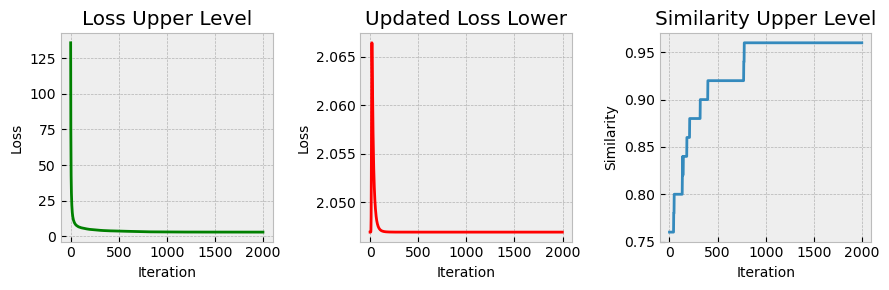

In [15]:
"Running algorithm on online dictionary learning"
Delta = 3
num_atoms = 50
max_iter = 2000

threshold = 0.95

_ , _ , _ = online_dict_learning(old_data,new_data, num_atoms,D_final_lower,x_final_lower, max_iter)

In [ ]:
#################################